<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Workbook - Week 5

# Tasks

### 5.1:  European Call Option

1. Write code to generate Monte Carlo approximations to a European call option with parameters $S_0=94.68$, $T=1$, $X=100$, $r=0.05$, $q=0.02$ and $\sigma=0.4$.

In [1]:
import numpy as np
prng = np.random.default_rng(seed=8675309) # create a random number generator and reset the starting value

2. code up the Monte Carlo solver into a function

In [2]:
from math import exp, sqrt

def estimateEuropeanCall( N, Szero, r, q, sigma, T, X, rng ):
    # Generate N values of phi
    phiVals = rng.normal( loc=0.0, scale=1.0, size=N )
    
    # Then find values for the stock and the option
    stockVals = Szero * np.exp( (r-q-0.5*sigma*sigma)*T + sigma*sqrt(T)*phiVals ) 
    callOptionVals = [s - X if (s - X) > 0.0 else 0.0 for s in stockVals]
    
    # Finally, take the mean of the simulated option values,
    # discount it, and return.
    value = np.mean(callOptionVals) * exp(-r * T)
    return( value )

3. run the function several times with the same value of $N$, what do the results look like?

In [3]:
# Parameters of the market
S_0 = 94.68 # Price at t=0
T = 1 # time at expiry
X = 100 # option price
r = 0.05 # risk-free interest rate
q = 0.02 # dividend return
sigma = 0.4 # volatility

# Parameters of the Monte-Carlo simulation
N = 100
nReps = 10 

[estimateEuropeanCall( N, S_0, r, q, sigma, T, X, prng ) for j in range(nReps)]

[11.707740459149678,
 8.937697061479367,
 13.485681776177623,
 14.103484398147359,
 11.019839642539848,
 10.343110270332167,
 9.253203436359806,
 7.914187517707165,
 21.310665449841828,
 14.18148564749702]

4. run the function for different values of $N=1000,2000,...$ and plot out the results, are they what you expected? Can you identify features of the graph?

In [4]:
# Assemble results for a range of sample sizes
nSizes = 10 
repsPerSize=100
sampleSize = [1000*int(pow(2,j+1)) for j in range(nSizes)]
results = np.zeros((nSizes, repsPerSize))
for j in range(nSizes):
    N = sampleSize[j]
    for k in range(repsPerSize):
        results[j,k] = estimateEuropeanCall( N, S_0, r, q, sigma, T, X, prng )

# Look at a few of them    
results[0:5,0:5]                  

array([[12.6585856 , 15.57504982, 15.13058564, 14.24991126, 14.96601153],
       [13.59079526, 13.33167271, 13.66235043, 13.99103124, 13.88938881],
       [13.89077868, 13.73471583, 13.1943006 , 13.82857479, 14.18712877],
       [13.66774842, 13.867067  , 13.52270289, 13.64665098, 13.08536138],
       [14.00323857, 13.58809837, 13.99465564, 13.83219842, 13.8463674 ]])

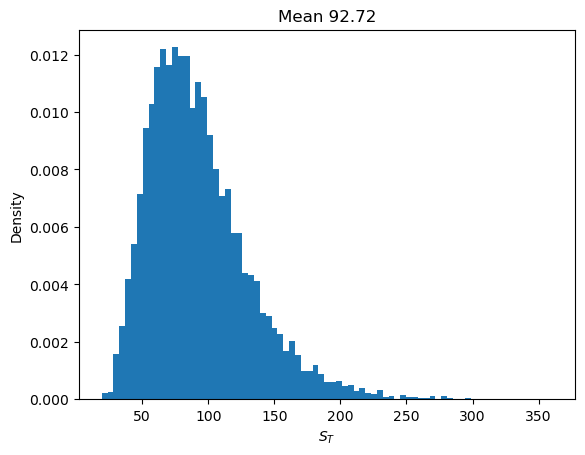

In [5]:
import matplotlib.pyplot as plt

# Generate N values of phi
N = 10000
phiVals = prng.normal( loc=0.0, scale=1.0, size=N )

# Then find values for the stock and the option
stockVals = S_0 * np.exp( (r-q-0.5*sigma*sigma)*T + sigma*sqrt(T)*phiVals ) 

# Plot a histogram of discounted stock vals
plt.hist( exp(-r*T) * stockVals, bins="fd", density=True )
plt.xlabel( "$S_T$" )
plt.ylabel( "Density" )
plt.title( "Mean {:.2f}".format(np.mean(stockVals) * exp(-r*T) ))

plt.show()

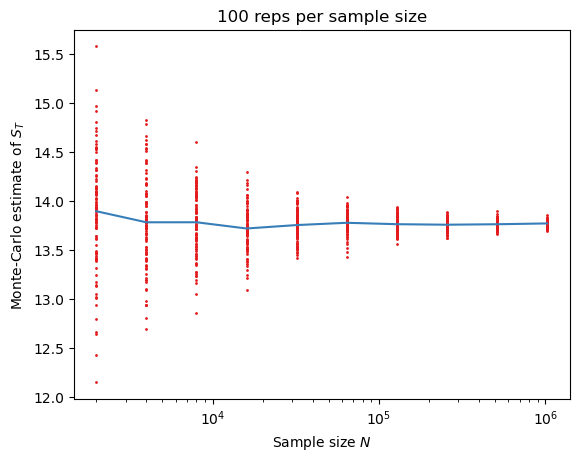

In [6]:
# Choose some pleasing colors
cmap = plt.colormaps["Set1"]
set_pal = cmap(range(0,9))

for j in range(nSizes):
    plt.semilogx( np.repeat(sampleSize[j], repsPerSize), results[j,], color=set_pal[0], marker=".", markersize=2, linestyle='none' )
    
# Add a line running through the means of the reps
meanResult = np.mean( results, axis=1 ) # Takes mean across rows
plt.semilogx( sampleSize, meanResult, color=set_pal[1] )
    
# Add titles
plt.xlabel( "Sample size $N$" )
plt.ylabel( "Monte-Carlo estimate of $S_T$" )
plt.title( "{} reps per sample size".format(repsPerSize) )

plt.savefig('Figures/MonteCarloEuropeanOptionPrice.pdf', format='pdf', bbox_inches='tight')

### Analysing Errors

5. calculate the exact value of the call option using numerical integration or the analytic formula, to be denoted $V_\text{exact}$

In [7]:
from scipy.integrate import quad
from scipy.stats import norm
from math import sqrt, log

# Arrange to integrate over the log-normal distrib
lnMean = log(S_0) + (r-q-0.5*sigma*sigma)*T
lnStdDev = sigma * sqrt(T)
discount = exp(-r*T)

def integrand(x):
    pdfLogX = norm.pdf(log(x), loc=lnMean, scale=lnStdDev) # normal distrib over log(x)
    pdfX = pdfLogX / x # Change-of-variable formula gives corresponding density in x-space
    return( (x - X)*discount*pdfX )

vExact = quad( integrand, X, np.inf )[0]
vExact

13.764201626260244

In [8]:
# Do a Monte-Carlo estimate with big N
estimateEuropeanCall( int(pow(2,22)), S_0, r, q, sigma, T, X, prng )

13.743894271509673

6. estimate the value of $\eta$ for the call option, and plot the lines $$V_\text{exact}\pm\frac{\eta}{\sqrt{n}}$$ does the picture look like you would expect?

The table of results constructed above should help. We can compute sums-of-squared differences for each sample size and then estimate $\eta^2$. 

There's a small technical issue in that our results &mdash; both those tabulated in `results` and the numerical integral in `vExact` &mdash; have been discounted with a factor of $e^{-rT}$, while the quantity $\eta^2$ is mentioned in the context of the Central Limit Theorem:
$$\sqrt{n}\left(\frac{1}{n}\sum_{i=1}^nV(S_T^i)-E_t^Q[V(S_T)]\right)\xrightarrow{d} N(0,\eta^2) .$$ 
Thus if we want the $\eta^2$ mentioned above, we need to undo the discounting.

In [10]:
# Get differences from the exact value and reverse the discounting
# to get differences at time T.
deevs = exp(r*T) * (results - vExact)

# Now use these to estimate eta^2
deevSq = np.multiply( deevs, deevs ) # elementwise product
varEstimates = np.mean( deevSq, axis=1 ) # takes means across rows
etaSqEstimates = np.multiply( varEstimates, sampleSize )
etaEstimates = np.sqrt( etaSqEstimates )
etaEstimates

array([27.90144909, 30.30461582, 30.19616756, 30.01826134, 27.70872141,
       27.88803153, 29.06644995, 27.93253508, 30.6571053 , 29.90040553])

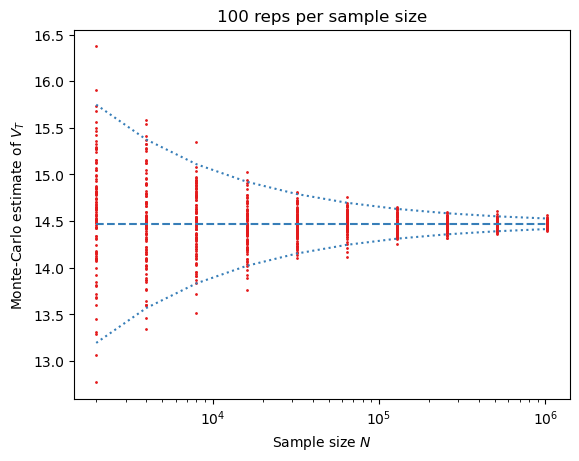

In [12]:
# As we are still looking at convergence related ot the cetral 
# limit theorem, we should remove discounting here too.

for j in range(nSizes):
    plt.semilogx( np.repeat(sampleSize[j], repsPerSize), exp(r*T)*results[j,], color=set_pal[0], marker=".", markersize=2, linestyle='none' )
    
# Add a dashed line at vExact
plt.semilogx( sampleSize, np.repeat(exp(r*T)*vExact, nSizes), color=set_pal[1], linestyle="dashed" )
    
# Add dotted envelopes forming a 95% confidence band 
offset = 1.96 * np.mean(etaEstimates) / np.sqrt(sampleSize)
plt.semilogx( sampleSize, exp(r*T)*vExact + offset, color=set_pal[1], linestyle="dotted" )
plt.semilogx( sampleSize, exp(r*T)*vExact - offset, color=set_pal[1], linestyle="dotted" )

# Add titles
plt.xlabel( "Sample size $N$" )
plt.ylabel( "Monte-Carlo estimate of $V_T$" )
plt.title( "{} reps per sample size".format(repsPerSize) )

plt.savefig('Figures/EtaEstimate.pdf', format='pdf', bbox_inches='tight')

7. Try running the same analysis on a put option, a binary option or any other payoff. Are the results always the same?

We'll consider an up-and-in barrier option that pays-off like a call option if, for any sampled time in $0 \leq t \leq T$, the price of the underlying meets or exceeds a threshold that's 20% higher than the initial price, $S_0$. If the barrier isn't crossed, the option pays nothing. For this case, we need to use Euler-Maruyama paths.

In [13]:
# Define a function that constructs N paths, each with K steps (and so K+1 values).
# We'll store the result in a (K+1)-by-N matrix, with one path per column. 
def generatePaths( N, K, S_0, T, X, r, q, sigma, rng ):
    # Work out the timestep
    dt = T/K

    # Generate all the values from thr Weiner process at a stroke
    dwMat = rng.normal( 0.0, sqrt(dt), size=(K, N) )

    # Initialise the result and install the initila value
    pathMat = np.zeros( (K+1, N) )
    pathMat[0,:] = S_0

    # Do the remaining steps
    for j in range(K):
        # The line below works with whole rows of the matrices, which
        # is equivalent to doing the whole collection of nPaths paths
        # at a stroke.
        pathMat[j+1,:] = pathMat[j,:]*(1.0 + (r - q)*dt + (sigma * dwMat[j,:]))

    return pathMat

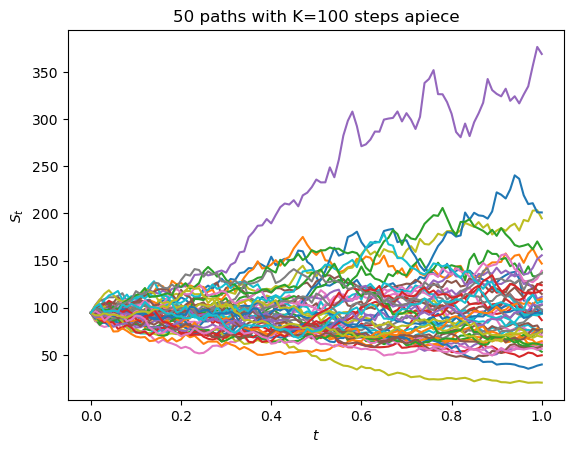

In [14]:
# As a test, generate some paths and plot them.
N = 50
K = 100
pathMat = generatePaths( N, K, S_0, T, X, r, q, sigma, prng )

# Get the times corresponding to the points in the path
dt = T/K
tVals = np.array( [j*dt for j in range(K+1)] )

plt.plot( tVals, pathMat )
plt.xlabel( "$t$" )
plt.ylabel( "$S_t$" )
plt.title( f"{N} paths with K={K} steps apiece" )
plt.show()


In [15]:
# Define a function that takes a single path and returns the payoff
def barrierPayoff( S_thresh, S_path, X ):
    if( np.any(S_path >= S_thresh) ):
        payoff = max( S_path[-1] - X, 0.0 ) # S_path[-1] is final entry in path, S(T),
    else:
        # Option never activated.
        payoff = 0.0

    return( payoff )

In [17]:
# Define a function that estimates the discounted,
# expected payoff and so estimates the value of the option
def estimateBarrierOptionVal( nPaths, K, S_thresh, S_0, T, X, r, q, sigma, rng ):
    pathMat = generatePaths( nPaths, K, S_0, T, X, r, q, sigma, rng )
    payoffs = np.zeros( nPaths ) 
    for j in range(nPaths):
        payoffs[j] = barrierPayoff( S_thresh, pathMat[:,j], X )

    # Return the mean of the estimates, but don't discount
    return np.mean(payoffs) 

Do a computation analogous to the one above, where we repeatedly simulate to compute the payoff for a range of values of $N$. The result is `nSizes-by-repsPerSize` matrix whose `j`-th row contains the results of simulations involving `sampleSize[j]` paths.

In [18]:
# Set the theshold and the number of steps
K = 100
thresh_factor = 1.2
S_thresh = thresh_factor * S_0

In [19]:
# Get many estimates of the expected payoff
barrierResults = np.zeros((nSizes, repsPerSize))
for j in range(nSizes):
    N = sampleSize[j]
    for k in range(repsPerSize):
        barrierResults[j,k] = estimateBarrierOptionVal( N, K, S_thresh, S_0, T, X, r, q, sigma, prng )

In [20]:
# Estimate the eta,
varEstimates = np.var( barrierResults, axis=1 ) # variances across rows
etaEstimates = np.sqrt(varEstimates * sampleSize) # we expect the variance to decrease like 1/N
vGrandMean = np.mean( barrierResults )
print( f"Mean of all estimates for value of option C(S_0, 0)={vGrandMean:.4f}" )

Mean of all estimates for value of option C(S_0, 0)=14.3665


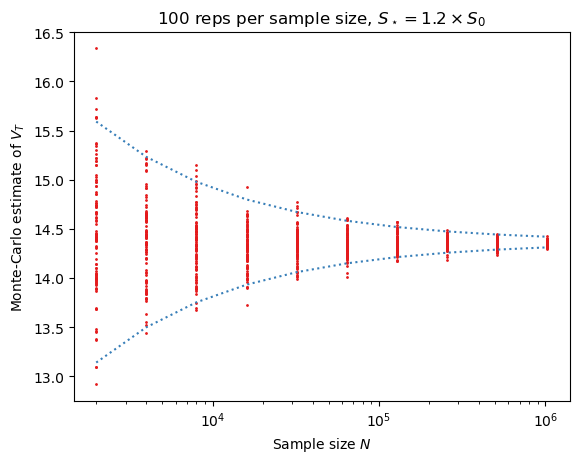

In [21]:
for j in range(nSizes):
    plt.semilogx( np.repeat(sampleSize[j], repsPerSize), barrierResults[j,:], color=set_pal[0], marker=".", markersize=2, linestyle='none' )
        
# Add dotted envelopes forming a 95% confidence band 
offset = 1.96 * np.mean(etaEstimates) / np.sqrt(sampleSize)
plt.semilogx( sampleSize, vGrandMean + offset, color=set_pal[1], linestyle="dotted" )
plt.semilogx( sampleSize, vGrandMean - offset, color=set_pal[1], linestyle="dotted" )

# Add titles
plt.xlabel( "Sample size $N$" )
plt.ylabel( "Monte-Carlo estimate of $V_T$" )
plt.title( f"{repsPerSize} reps per sample size, $S_\\star = {thresh_factor} \\times S_0$" )

plt.savefig('Figures/EtaEstimate.pdf', format='pdf', bbox_inches='tight')

Thus the behaviour is not unlike that above, save that this option is a bit less valuable at $t=0$ as, at t hat point, we don't know whether it will ever activate..

### 5.3: Evaluating Efficiency

Following functions are required for the last part:

In [22]:
import numpy
rng = numpy.random.default_rng(seed=0) # create a random number generator and reset the starting value

def monteCarlo1(S_0,T,X,r,q,sigma,n,K):
    dt = T/K
    dW = rng.normal(0.0,numpy.sqrt(dt),size=(n,K))
    sum = 0.0
    for i in range(0,n):
        St=S_0
        for k in range(0,K):
            St=St + (r-q)*St*dt + sigma*St*dW[i][k]
        sum += max(St-X,0.0)
    return sum/n *numpy.exp(-r*T)

def monteCarlo2(S_0,T,X,r,q,sigma,n):
    WT = rng.normal(0.0,numpy.sqrt(T), n)
    sum = 0.0
    for i in range(0,n):
        STi = S_0*numpy.exp((r-q-0.5*sigma*sigma)*T+sigma*WT[i])
        sum += max(STi-X,0.0)
    return sum/n *numpy.exp(-r*T)

def monteCarlo3(S_0,T,X,r,q,sigma,n):
    ST = rng.lognormal(numpy.log(S_0) + (r-q-0.5*sigma*sigma)*T, sigma*numpy.sqrt(T), n)
    sum = 0.0
    for i in range(0,n):
        sum += max(ST[i]-X,0.0)
    return sum/n *numpy.exp(-r*T)

8. Plot out the results of $V_n$ vs $n$ for each of the methods (you can choose $K=100$). Are the results converging on the correct value?

In [23]:
# Do as above, but with fewer reps
nSizes = 8 
repsPerSize=20
sampleSize = [1000*int(pow(2,j+1)) for j in range(nSizes)]

# Define a function that generates samples and plots reults
def plotConvergence( sampleSize, repsPerSize, script, ax, title ):
    # Generate results
    results = np.zeros((nSizes, repsPerSize))
    for j in range(nSizes):
        N = sampleSize[j]
        for k in range(repsPerSize):
            results[j,k] = eval( script )
    
    # Plot them on the axes
    for j in range(nSizes):
        ax.semilogx( np.repeat(sampleSize[j], repsPerSize), results[j,], color=set_pal[0], marker=".", markersize=2, linestyle='none' )

    # Add a dashed line at vExact
    ax.semilogx( sampleSize, np.repeat(vExact, nSizes), color=set_pal[1], linestyle="dashed" )


    # Add titles
    ax.set_xlabel( "Sample size $N$" )
    ax.set_ylabel( "Monte-Carlo estimate of $V_T$" )
    ax.set_title( title )

Draw a three-panel plot showing all the simulations

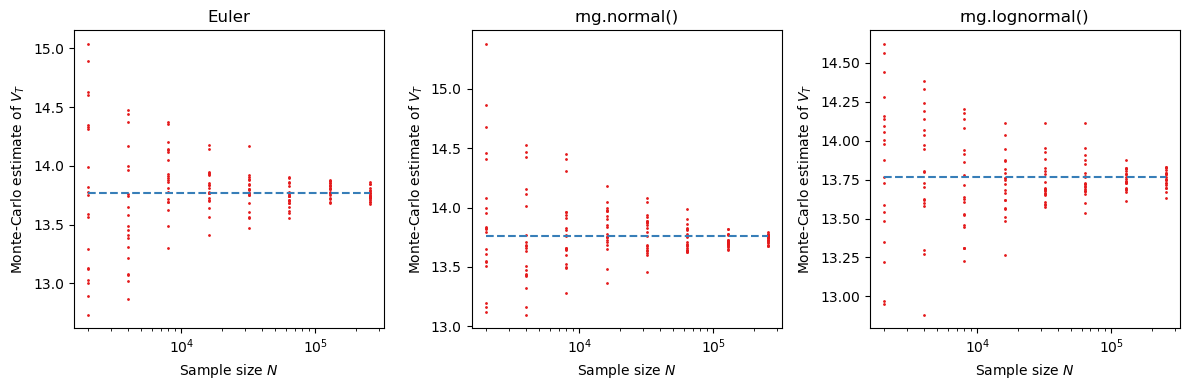

In [24]:
# Begin by the dimensions of the plot
heightInInches = 4
widthInInches = 12
myFig, myAxes = plt.subplots(1,3, figsize=[widthInInches,heightInInches])

# Make the three panels
K = 100
plotConvergence( sampleSize, repsPerSize, "monteCarlo1(S_0, T, X, r, q, sigma, N, K)", myAxes[0], "Euler" )
plotConvergence( sampleSize, repsPerSize, "monteCarlo2(S_0, T, X, r, q, sigma, N)", myAxes[1], "rng.normal()" )
plotConvergence( sampleSize, repsPerSize, "monteCarlo3(S_0, T, X, r, q, sigma, N)", myAxes[2], "rng.lognormal()" )

# Save the figure
myFig.tight_layout()
plt.savefig('Figures/ThreeMonteCarloApproaches.pdf', format='pdf', bbox_inches='tight')        

9. Can you generate a confidence interval for a result with $n=1000000$ paths?

In [25]:
# Begin by estimating eta from 1000 samples, each based on 1000 simulated values
N = 1000
mySamples = [monteCarlo3(S_0,T,X,r,q,sigma,N) for j in range(N)]
etaEstimate = np.std(mySamples) * sqrt(N)

# Now construct a confidence interval for an estimate based on 1000000 simulated values
confLevel = 0.95
alpha = 1.0 - confLevel

CI_midpoint = np.mean(mySamples)
CI_halfWidth = norm.ppf(1.0 - 0.5*alpha) * (etaEstimate / sqrt(1000000))
confInterval = np.array( (CI_midpoint - CI_halfWidth, CI_midpoint + CI_halfWidth) )
print( "Confidence interval for a 10e6 element sample is", confInterval )

Confidence interval for a 10e6 element sample is [13.75284264 13.85696839]


10. Run the code timings below -- can you explain why some codes take longer than others?

The Euler approach is slowest as it has to calculate whole $K$-step paths worth of prices from $t=0$ to $T=1$, while the one that users `rng.normal()` has to both generate normally-distributed random numbers and then apply `numpy.exp()`. 

In [26]:
from timeit import timeit
n = 10000
K = 100
S_0=94.68
T=1
X=100
r=0.05
q=0.02
sigma=0.4

script="monteCarlo1(S_0,T,X,r,q,sigma,n,K)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )
print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

script="monteCarlo2(S_0,T,X,r,q,sigma,n)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )
print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

script="monteCarlo3(S_0,T,X,r,q,sigma,n)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )
print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

Time taken to run  100  simulations with  10000  paths is 32.079712709004525  seconds.
Time taken to run  100  simulations with  10000  paths is 0.8280387500417419  seconds.
Time taken to run  100  simulations with  10000  paths is 0.2259428750257939  seconds.


11. Can you improve the run times using `numba` or `cython`?

Yes, probably. I had trouble understanding how to use numpy's random number machinery with numba, but then found a [helpful page](https://numba.readthedocs.io/en/stable/reference/numpysupported.html) that explained what to do.

In [27]:
from numba import jit
import numpy as np

rng = np.random.default_rng(seed=8675309)

@jit
def monteCarlo1a(S_0,T,X,r,q,sigma,n,K,prng):
    dt = T/K
    dW = prng.normal(0.0,numpy.sqrt(dt),size=(n,K))
    sum = 0.0
    for i in range(0,n):
        St=S_0
        for k in range(0,K):
            St=St + (r-q)*St*dt + sigma*St*dW[i][k]
        sum += max(St-X,0.0)
    return sum/n *numpy.exp(-r*T)

# Have a go
monteCarlo1a(S_0,T,X,r,q,sigma,n,K,rng)

13.505165015297003

It seems that numba can speed-up the Euler approach by a factor of 30 or so.

In [28]:
script="monteCarlo1a(S_0,T,X,r,q,sigma,n,K,rng)"
codeRuns = 100
timeSimulate = timeit( script,number=codeRuns,globals=globals() )
print("Time taken to run ",codeRuns," simulations with ",n," paths is", timeSimulate," seconds.")

Time taken to run  100  simulations with  10000  paths is 0.8813470419845544  seconds.
